In [2]:
#import cleaned Superstore dataset

import pandas as pd

df = pd.read_csv("Superstore_cleaned_final.csv", parse_dates=["order_date", "ship_date"])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   row_id            9800 non-null   int64         
 1   order_id          9800 non-null   object        
 2   order_date        9800 non-null   datetime64[ns]
 3   ship_date         9800 non-null   datetime64[ns]
 4   ship_mode         9800 non-null   object        
 5   customer_id       9800 non-null   object        
 6   customer_name     9800 non-null   object        
 7   segment           9800 non-null   object        
 8   city              9800 non-null   object        
 9   state             9800 non-null   object        
 10  postal_code       9800 non-null   float64       
 11  region            9800 non-null   object        
 12  product_id        9800 non-null   object        
 13  category          9800 non-null   object        
 14  sub_category      9800 n

In [3]:
#Check Shape of dataset

print(df.shape)

(9800, 24)


In [4]:
#Check if any values failed to parse

failed_order = df['order_date'].isna().sum()
failed_ship = df['ship_date'].isna().sum()
print(failed_order)
print(failed_ship)

0
0


In [5]:
#Predicting next 7 days sales

daily_sales = (df.groupby('order_date',as_index=False)['sales'].sum().rename(columns={'order_date':'ds','sales':'y'}))

#groupby - groups dataset by order_date(one row for each day of sales)
#['sales'] - selecting only sales column as we want just sum of the sales on a day
#Prophet has strict naming requirements. The date columns must me named 'ds' and value column must be named 'y'


In [6]:
#Check the daily_sales column

print(daily_sales)

             ds          y
0    2015-01-03    16.4480
1    2015-01-04   288.0600
2    2015-01-05    19.5360
3    2015-01-06  4407.1000
4    2015-01-07    87.1580
...         ...        ...
1225 2018-12-26   814.5940
1226 2018-12-27   177.6360
1227 2018-12-28  1657.3508
1228 2018-12-29  2915.5340
1229 2018-12-30   713.7900

[1230 rows x 2 columns]


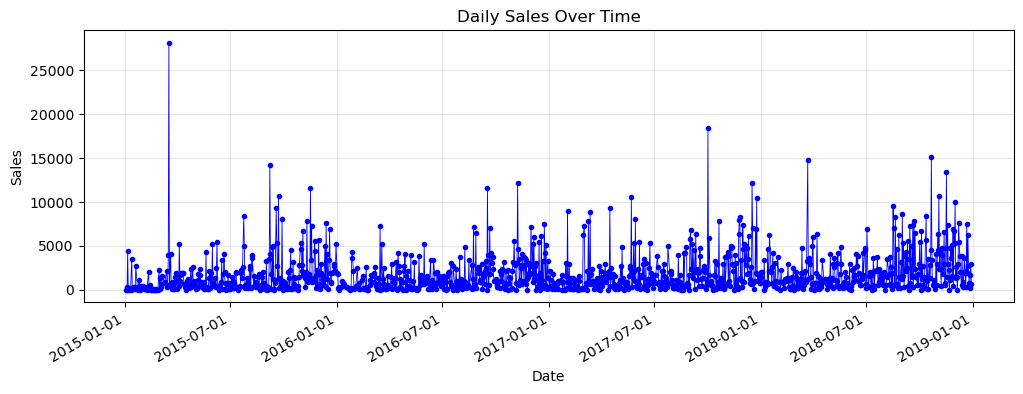

In [7]:
#Visualize daily sales over time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,4))
plt.plot(daily_sales['ds'], daily_sales['y'], marker='.', linewidth=0.6, color='blue')
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(alpha=0.3)


# Format x-axis to show full dates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate for readability
plt.show()

c:\Users\Admin\.ms-ad\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters 7-day forecast:
        ds        yhat
2018-12-31 3456.120194
2019-01-01 3386.753189
2019-01-02 1838.855183
2019-01-03 1189.760841
2019-01-04 3312.600421
2019-01-05 3943.033953
2019-01-06 3360.738285


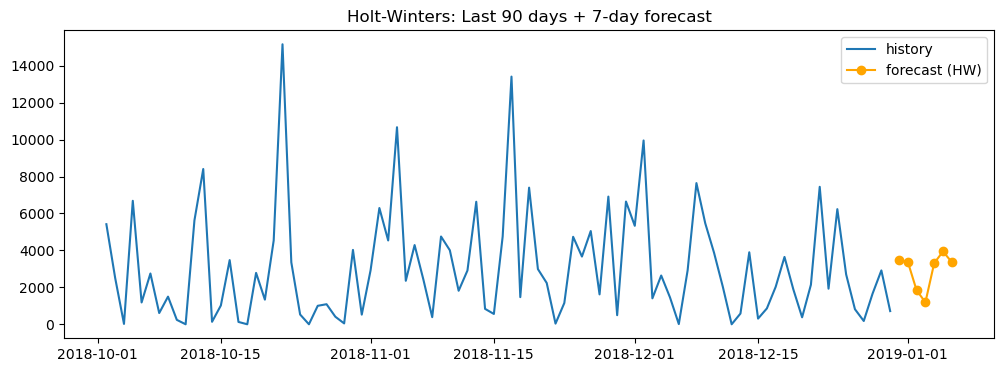

In [8]:
# Holt-Winters fallback to predict next 7 days forecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt

ts = daily_sales.set_index('ds')['y'].asfreq('D')    # your daily series
ts = ts.fillna(0)   # fill gaps (or use .ffill() if you prefer)

hw = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=7, initialization_method="estimated")
hw_fit = hw.fit(optimized=True)

# Forecast 7 days
pred_hw = hw_fit.forecast(7)

# Convert to DataFrame for readability
pred_df = pred_hw.reset_index()
pred_df.columns = ['ds', 'yhat']

print("Holt-Winters 7-day forecast:")
print(pred_df.to_string(index=False))

# Plot last 90 days + forecast
future_idx = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
plt.figure(figsize=(12,4))
plt.plot(ts[-90:], label='history')
plt.plot(future_idx, pred_hw.values, marker='o', label='forecast (HW)', color='orange')
plt.legend(); plt.title('Holt-Winters: Last 90 days + 7-day forecast'); plt.show()


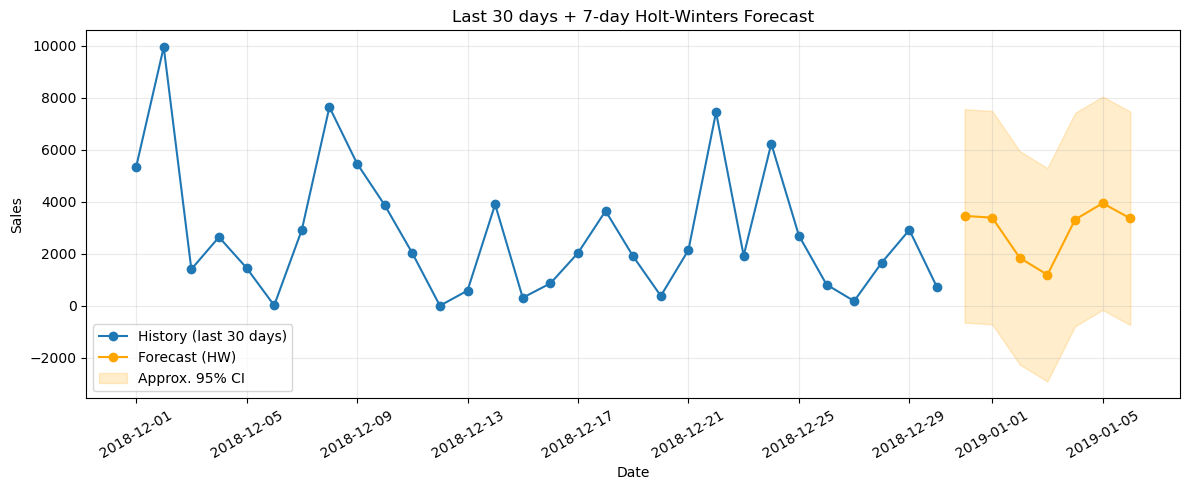

Saved forecast_next_7_days.csv


In [9]:
# Plot last 30 days of history + 7-day HW forecast with approximate 95% CI
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assumes these already exist in your session:
# ts            -> pd.Series indexed by ds (daily), the historical series used for HW
# hw_fit        -> fitted ExponentialSmoothingResults object
# pred_df       -> DataFrame with columns ['ds','yhat'] for the 7 forecast days

# 1) Prepare history and forecast frames
history_days = 30
hist = ts[-history_days:].reset_index().rename(columns={ts.name: 'y'})  # last 30 days
forecast = pred_df.copy()
forecast['ds'] = pd.to_datetime(forecast['ds'])

# 2) Approximate 95% CI for forecast using residual std
#    residuals = actual - fitted_values (aligned)
fitted = hw_fit.fittedvalues  # aligned with ts index
resid = (ts - fitted).dropna()
resid_std = resid.std()

z = 1.96  # 95% approx
forecast['yhat_lower'] = forecast['yhat'] - z * resid_std
forecast['yhat_upper'] = forecast['yhat'] + z * resid_std

# 3) Plot
plt.figure(figsize=(12,5))

# plot historical last 30 days
plt.plot(hist['ds'], hist['y'], label=f'History (last {history_days} days)', marker='o')

# plot forecast points
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (HW)', marker='o', color='orange')

# plot CI as shaded area
plt.fill_between(forecast['ds'].astype('datetime64[ns]'),
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='orange', alpha=0.2, label='Approx. 95% CI')

# formatting
plt.title(f'Last {history_days} days + 7-day Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=30)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# 4) Save forecast to CSV
forecast_out = forecast[['ds','yhat','yhat_lower','yhat_upper']].copy()
forecast_out.to_csv('forecast_next_7_days.csv', index=False)
print("Saved forecast_next_7_days.csv")
